# Final Practice
**Author: Jorge Vázquez Pérez**

## Table of Contents

1. [Preprocessing](#apartado1)
2. [Develop a classical neural network (NN)](#apartado2)
3. [Develop a quantum neural network (QNN)](#apartado3)
4. [Develop a classical SVM](#apartado4)
5. [Develop a quantum SVM](#apartado5)
6. [Conclusions](#apartado6)

We start by loading the dataset.

In [1]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

# Load dataset
cancer = datasets.load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.2, random_state=42)

/home/jvazquez/miniconda3/envs/basic-quantum/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Preprocessing <a class="anchor" id="apartado1"></a>

Now that the dataset has been successfully loaded into the notebook, we can proceed with the data preprocessing. The shape of the data is as follows.

In [2]:
print("Shape of train set is: ", X_train.shape)
print("Shape of test set is: ", X_test.shape)

print("Shape of train labels is: ", y_train.shape)
print("Shape of test labels is: ", y_test.shape)

Shape of train set is:  (455, 30)
Shape of test set is:  (114, 30)
Shape of train labels is:  (455,)
Shape of test labels is:  (114,)


As a next step, we will transform the value of each feature from a float of an arbitrary interval to a 32-bit floating-point number ranging from 0 to 1. This transformation serves various purposes, including enhancing numerical stability, expediting convergence and improving weight initialization, among others.

In [3]:
from sklearn.preprocessing import MinMaxScaler

print(f"Before scaled: \n{X_train[0]}")

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

print(f"After scaled: \n{X_train[0]}")

Before scaled: 
[9.029e+00 1.733e+01 5.879e+01 2.505e+02 1.066e-01 1.413e-01 3.130e-01
 4.375e-02 2.111e-01 8.046e-02 3.274e-01 1.194e+00 1.885e+00 1.767e+01
 9.549e-03 8.606e-02 3.038e-01 3.322e-02 4.197e-02 9.559e-03 1.031e+01
 2.265e+01 6.550e+01 3.247e+02 1.482e-01 4.365e-01 1.252e+00 1.750e-01
 4.228e-01 1.175e-01]
After scaled: 
[0.06552721 0.25769361 0.07732252 0.03436883 0.48722578 0.41750565
 0.73336457 0.21744533 0.50400427 0.64237574 0.07818215 0.18427334
 0.05314988 0.02029892 0.26637658 0.62943491 0.76717172 0.62928585
 0.63623129 0.29933115 0.05964476 0.28331557 0.05597072 0.02508436
 0.523195   0.44938009 1.         0.60137457 0.52493594 0.52950153]


Concerning the tags, we convert them into a binary vector. This conversion is performed to ensure uniqueness, avoid ordinal assumptions and simplify model integration and interpretation. The usefulness of this approach becomes more evident when dealing with non-numerical categories.

One can notice that we reserve the original labels (without one-hot encoding) under the `y_orig_train` and `y_orig_test` for the train and test sets, respectively. This is because the SVM models require a vector without one-hot encoding.

In [4]:
from tensorflow.keras.utils import to_categorical

print(f"Before one-hot encoding: \n{y_train[:5]}")

y_orig_train = y_train
y_orig_test = y_test

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(f"After one-hot encoding: \n{y_train[:5]}")

2024-01-16 19:10:46.163694: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-16 19:10:46.196164: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-16 19:10:46.196193: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-16 19:10:46.197051: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-16 19:10:46.202822: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-16 19:10:46.203683: I tensorflow/core/platform/cpu_feature_guard.cc:1

Before one-hot encoding: 
[1 0 1 1 1]
After one-hot encoding: 
[[0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


Last but not least, we create a validation subset from the training set by splitting the data into two sets: 80% for training and 20% for validation. For this the `sklearn` function `train_test_split` will be used. They will be called different that the original training set because the validation set is only going to be used on the classical NN. For the rest of the models the train and test sets will suffice, so we have to keep the originals intact.

In [5]:
from sklearn.model_selection import train_test_split

X1_train, X1_val, y1_train, y1_val = train_test_split(X_train, y_train, test_size=0.2, random_state=32)

## Develop a classical neural network (NN) <a class="anchor" id="apartado2"></a>

First we will define a function to plot different models and compare.

In [6]:
import matplotlib.pyplot as plt

def plot_models(histories):
    fig, axs = plt.subplots(2, len(histories), figsize=(18, 8))
    for i, history in enumerate(histories):
        history_dict = history.history
        epochs = range(1, len(history_dict['loss']) + 1)
        axs[0][i].plot(epochs, history_dict['loss'], 'b-o', label='Training loss')
        axs[0][i].plot(epochs, history_dict['val_loss'], 'r-o', label='Validation loss')
        axs[0][i].set_title('Model {}'.format(i+1))
        axs[0][i].set_xlabel('Epochs')
        axs[0][i].set_ylabel('Loss')
        axs[0][i].legend()

    for i, history in enumerate(histories):
        history_dict = history.history
        epochs = range(1, len(history_dict['loss']) + 1)
        axs[1][i].plot(epochs, history_dict['accuracy'], 'b-o', label='Training accuracy')
        axs[1][i].plot(epochs, history_dict['val_accuracy'], 'r-o', label='Validation accuracy')
        axs[1][i].set_title('Model {}'.format(i+1))
        axs[1][i].set_xlabel('Epochs')
        axs[1][i].set_ylabel('Accuracy')
        axs[1][i].legend()
    
    # Display the plot
    plt.tight_layout()
    plt.show()

### Structural hyperparameters <a class="anchor" id="apartado2.1"></a>

Now, let's delve into the structure of the neural network (NN). In this section, we will determine three key aspects: the number of hidden layers, the number of neurons per layer and the activation function of the neurons. This is indeed a challenging task, given the numerous possible combinations and the absence of a one-size-fits-all solution. We will base our decisions on the following guiding principles:

- Minimizing resource usage.
- Mitigating overfitting.
- Minimizing validation loss.

These three criteria will guide our decision-making process for defining the NN structure. Given the vast search space, when attempting to determine the value of a hyperparameter, we will fix the values of the other two to observe how that specific hyperparameter alone affects the results. Let's begin with the number of hidden layers.

2024-01-16 19:10:48.181561: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Training different models to compare... Done.


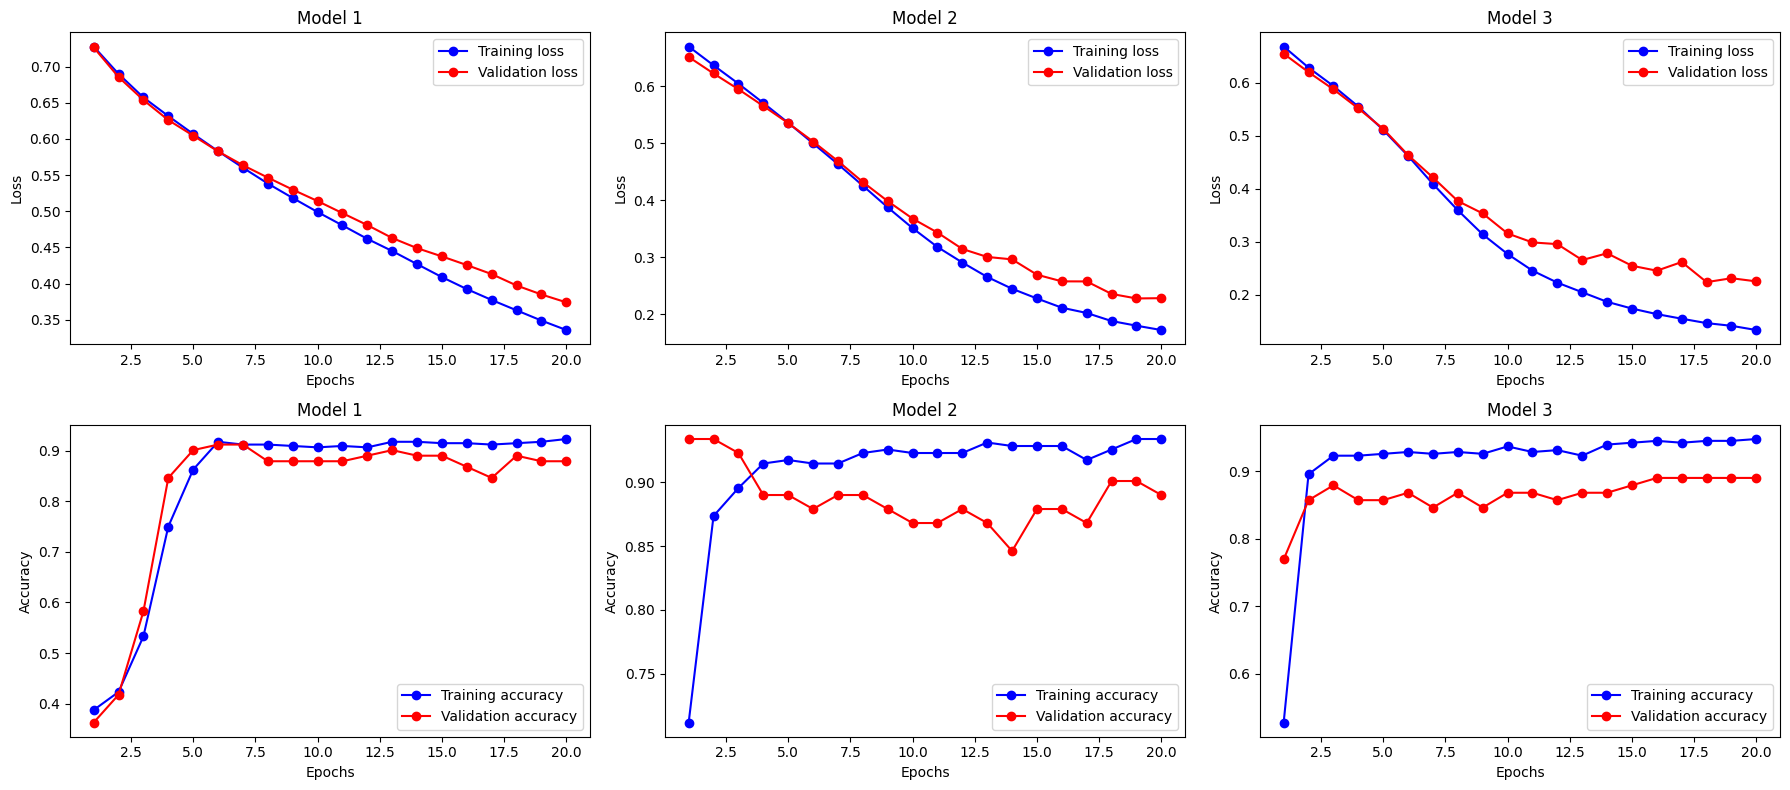

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Define the model
model1 = Sequential([
    Flatten(input_shape=(30,)),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')  # Output layer for 10 classes
])

# Define the model
model2 = Sequential([
    Flatten(input_shape=(30,)),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')  # Output layer for 10 classes
])

# Define the model
model3 = Sequential([
    Flatten(input_shape=(30,)),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')  # Output layer for 10 classes
])

for model in [model1, model2, model3]:
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

print("Training different models to compare...", end=" ")
history1 = model1.fit(X1_train, y1_train, epochs = 20, batch_size = 64, validation_data = (X1_val, y1_val), verbose=0)
history2 = model2.fit(X1_train, y1_train, epochs = 20, batch_size = 64, validation_data = (X1_val, y1_val), verbose=0)
history3 = model3.fit(X1_train, y1_train, epochs = 20, batch_size = 64, validation_data = (X1_val, y1_val), verbose=0)
print("Done.")

plot_models([history1, history2, history3])

In this case, we observe that the validation loss remains around 0.35 for the one layer model, 0.3 for the two layer model and 0.2 for three layer model. Looking at the accuracy, we see that one layer model reached 0.8, while two and three layer model achieve around 0.85. This makes us think that opting for a two hidden layer would be a prudent choice to minimize resource usage. Additionally, no overfitting seems to be appearing in any of the models, since the validation loss always maintains its resemblance to the training loss.

Now, let's proceed to determining the number of neurons per layer.

Training different models to compare... Done.


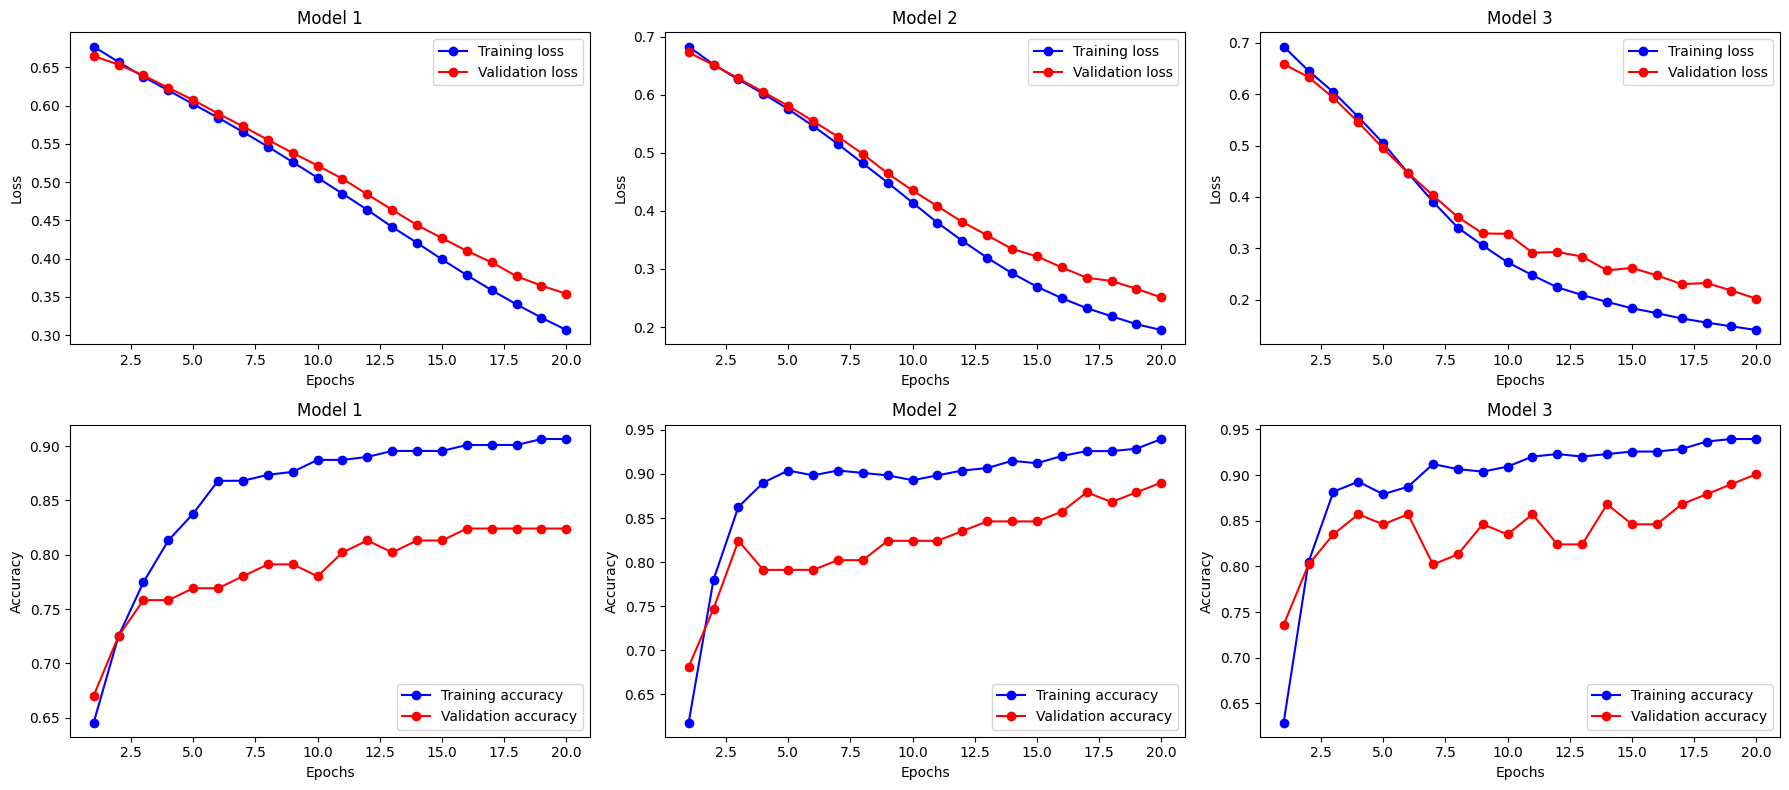

In [8]:
model1_ = Sequential([
    Flatten(input_shape=(30,)),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(2, activation='softmax')  # Output layer for 10 classes
])

model2_ = Sequential([
    Flatten(input_shape=(30,)),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')  # Output layer for 10 classes
])

model3_ = Sequential([
    Flatten(input_shape=(30,)),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')  # Output layer for 10 classes
])

for model in [model1_, model2_, model3_]:
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

print("Training different models to compare...", end=" ")
history1_ = model1_.fit(X1_train, y1_train, epochs = 20, batch_size = 64, validation_data = (X1_val, y1_val), verbose=0)
history2_ = model2_.fit(X1_train, y1_train, epochs = 20, batch_size = 64, validation_data = (X1_val, y1_val), verbose=0)
history3_ = model3_.fit(X1_train, y1_train, epochs = 20, batch_size = 64, validation_data = (X1_val, y1_val), verbose=0)
print("Done.")

plot_models([history1_, history2_, history3_])

In this case, the third model exhibits signs of overfitting due to the limited improvement achieved in the validation set compared to the training set. When considering the first and second models, we notice that the first one achieves at most around 0.35 of validation loss and 0.85 of validation accuracy, while the second model reaches almost 0.9 0f validation accuracy with almost 0.2 validation loss. And that is why we will choose a 32 neuron layers instead of 16 neuron layers.

Let's see the performance under the test set.

In [9]:
results = model2_.evaluate(X_test, y_test)

4/4 [==============================] - 0s 3ms/step - loss: 0.1669 - accuracy: 0.9386


Now, let's proceed to the final structural hyperparameter: comparing four activation functions.

In [10]:
activation_functions = ['relu', 'sigmoid', 'tanh', 'softmax']

results = {}
for activation in activation_functions:
    model = Sequential([
        Flatten(input_shape=(30,)),
        Dense(32, activation=activation),
        Dense(32, activation=activation),
        Dense(2, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    print(f"\nTraining model with {activation} activation...", end=" ")
    history = model.fit(X1_train, y1_train, batch_size = 64, validation_data=(X1_val, y1_val), epochs=20, verbose=0)
    print(f"Done.")

    score = model.evaluate(X_test, y_test, verbose=0)
    results[activation] = score[1]  # store the accuracy

print(f"------ Activation results --------\n\n")
for activation, accuracy in results.items():
    print(f"Accuracy with {activation} activation: {accuracy:.4f}")


Training model with relu activation... Done.

Training model with sigmoid activation... Done.

Training model with tanh activation... Done.

Training model with softmax activation... Done.
------ Activation results --------


Accuracy with relu activation: 0.9649
Accuracy with sigmoid activation: 0.8684
Accuracy with tanh activation: 0.9123
Accuracy with softmax activation: 0.6228


Looking at the accuracies, the decision falls between ReLU and tanh. We will choose ReLU for two reasons: its simplicity and its addressing of the vanishing gradient problem.

In [11]:
activation = 'relu'

### Learning parameters

When addressing learning parameters, we notice that the number of them increases compared to structural parameters. Specifically, we will focus on the following learning parameters: optimizer, learning rate, epochs, batch size and metrics.

In this case, instead of manually evaluating each hyperparameter while fixing the others to observe the impact of different values, we will adopt a more efficient technique using the `keras_tuner` package. This package provides methods like Bayesian search or grid search, which aim to explore a search space defined by us to find the best set of hyperparameters. For our scenario, we will provide a set of three values around the ones used in the previous section, as we have already achieved acceptable results with those values.

The only hyperparameter among those mentioned earlier that we won't search using this method is the batch size. Increasing the batch size primarily serves to reduce time resource consumption. In our case, we will maintain it at 32, as it is sufficiently small and does not create a significant bottleneck in terms of time consumption. We also do this to not make the search space even bigger for the grid search method adding another hyperparameter.

In [12]:
import tensorflow as tf
from keras_tuner import HyperModel
from keras_tuner.tuners import GridSearch

class MyHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential([
            Flatten(input_shape=(30,)),
            Dense(32, activation=activation),         
            Dense(32, activation=activation),
            Dense(2, activation='softmax')
        ])
    
        # Hyperparameters to tune
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])
        hp_optimizer = hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop'])
        hp_metric = hp.Choice('metrics', values=['accuracy', 'precision'])
    
        # Choose the optimizer
        if hp_optimizer == 'adam':
            optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
        elif hp_optimizer == 'sgd':
            optimizer = tf.keras.optimizers.SGD(learning_rate=hp_learning_rate)
        else:
            optimizer = tf.keras.optimizers.RMSprop(learning_rate=hp_learning_rate)
    
        model.compile(optimizer=optimizer,
                      loss='categorical_crossentropy',
                      metrics=hp_metric)
    
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            epochs=hp.Choice("epochs", [10, 15]),
            **kwargs,
        )    

# Create a GridSearch tuner
tuner = GridSearch(
    MyHyperModel(),
    objective='val_accuracy',
    max_trials=24,
    directory='tuner_dir',
    project_name='grid_search'
)

# Perform the hyperparameter search
tuner.search(X1_train, y1_train, batch_size=32, validation_data=(X1_val, y1_val))

Trial 24 Complete [00h 00m 00s]

Best val_accuracy So Far: 0.901098906993866
Total elapsed time: 00h 00m 24s


Once we have searched the hyperparameters, we can output their values and train a model with them in order to see the results.

In [13]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

optimizer = best_hps.get('optimizer')
learning_rate = best_hps.get('learning_rate')
metric = best_hps.get('metrics')
epochs = best_hps.get('epochs')
batch_size = 32

print(f""" The hyperparameter search is complete.
- Best optimizer: {optimizer}.
- Best learning rate: {learning_rate}.
- Best metric: {metric}.
- Best epochs: {epochs}.
""")

# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)

print("\nTraining the final model...", end=" ")
history = model.fit(X1_train, y1_train, epochs=epochs, batch_size=batch_size, validation_data=(X1_val, y1_val), verbose = 0)
print("Done.")

 The hyperparameter search is complete.
- Best optimizer: adam.
- Best learning rate: 0.001.
- Best metric: accuracy.
- Best epochs: 15.


Training the final model... Done.


And now, all the values of the hyperparameters have been obtained. Let's look at the validation loss and the validation accuracy of our model.

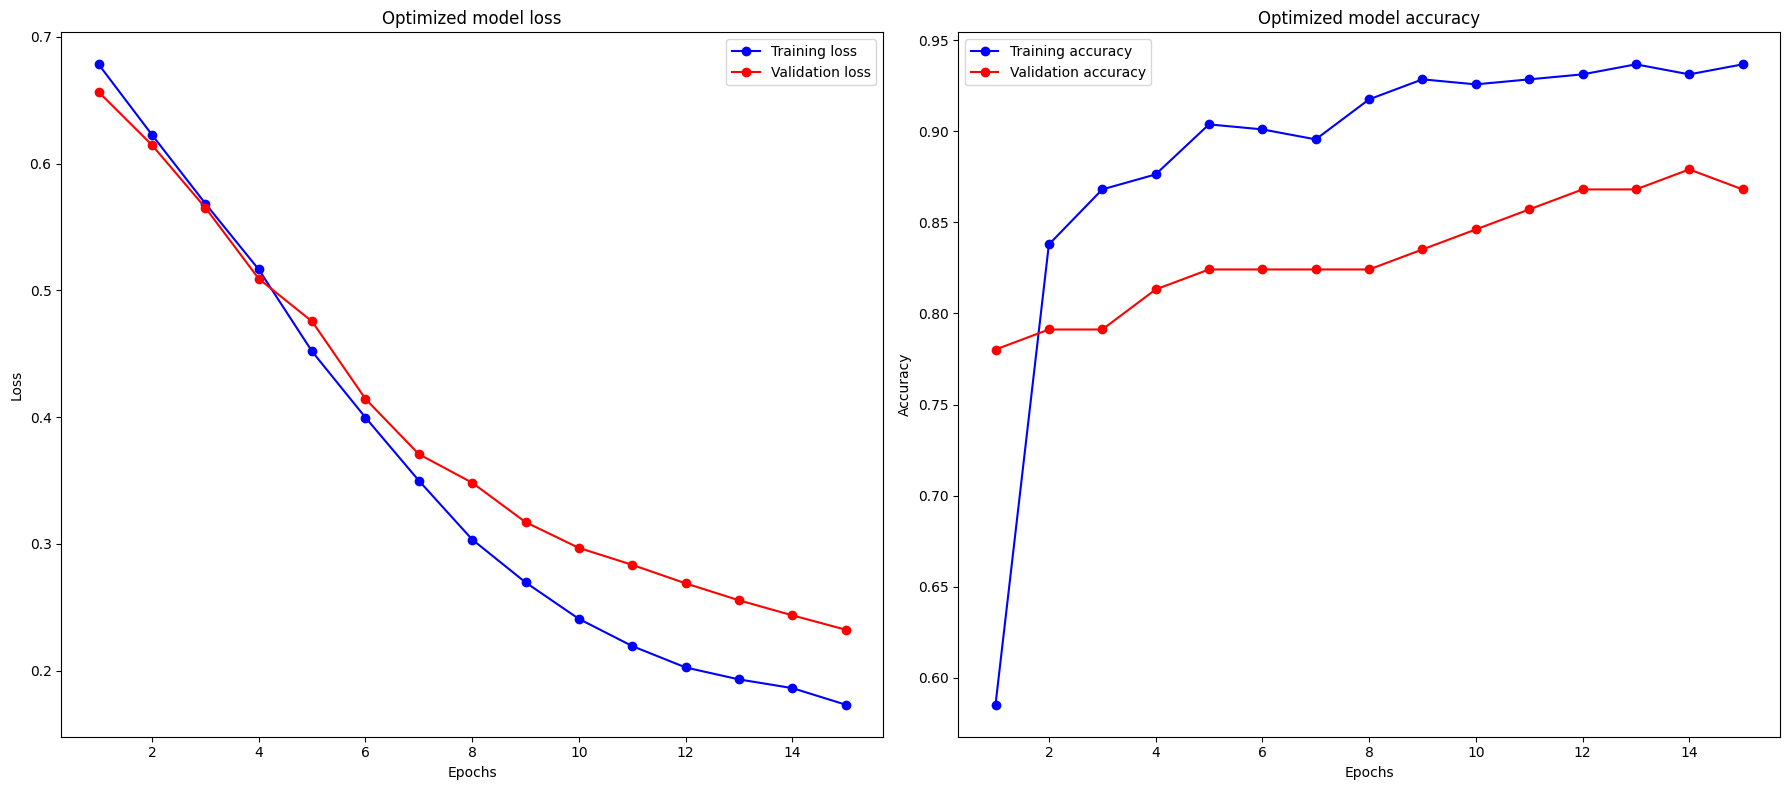

In [14]:
def plot_model(history_):
    fig, axs = plt.subplots(1, 2, figsize=(18, 8))
    history_dict = history.history
    epochs = range(1, len(history_dict['loss']) + 1)
    
    axs[0].plot(epochs, history_dict['loss'], 'b-o', label='Training loss')
    axs[0].plot(epochs, history_dict['val_loss'], 'r-o', label='Validation loss')
    axs[0].set_title('Optimized model loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[1].plot(epochs, history_dict['accuracy'], 'b-o', label='Training accuracy')
    axs[1].plot(epochs, history_dict['val_accuracy'], 'r-o', label='Validation accuracy')
    axs[1].set_title('Optimized model accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    
    # Display the plot
    plt.tight_layout()
    plt.show()

plot_model(history)

And, finally, we can test the model with the test data in order to obtain the actual accuracy of our model.

In [15]:
results = model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 4ms/step - loss: 0.1686 - accuracy: 0.9386


Although the results have nice accuracy, if we focus on the plot displayed we still see a slight overfitting. In the next section, using the hyperparameters obtained in this section we are going to see if its possible to reduce that overfitting in order to obtain a better accuracy on the test set.

## Regularization <a class="anchor" id="apartado3"></a>

In this section we are going to develop some regularization techniques in order to improve the overfitting of our model. In order to make this section lighter than the previous ones, we are going to make our analysis using the evaluation of the model agaist the test set, instead of looking at the graphic and comparing the validation data with the training data. Moreover, if some of these techniques make the results worse we are not going to explain why: the causes can be multiple and difficult to analyze. We will explain the theory behind these methods and apply them to our NN indiviually to see if we should incorporate them.

First, we will add a dropout layer in between the two hidden layers. In order to get the best dropout rate possible we will apply a bayesian search, similar to the grid search, but using a probabilistic model.

In [16]:
from keras_tuner.tuners import BayesianOptimization
from tensorflow.keras.layers import Dropout

def build_model(hp):
    
    model = Sequential([
        Flatten(input_shape=(30,)),
        Dense(32, activation=activation),        
        Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.05)),
        Dense(32, activation=activation),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=metric)
    return model

# Instantiate the BayesianOptimization tuner
tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=6,
    directory='tuner_dir',
    project_name='bayesian_optimization'
)

# Start the hyperparameter search
tuner.search(X1_train, y1_train,
             epochs=epochs,
             validation_data=(X1_val, y1_val))

Trial 6 Complete [00h 00m 02s]
val_accuracy: 0.8681318759918213

Best val_accuracy So Far: 0.901098906993866
Total elapsed time: 00h 00m 11s


In [17]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
dropout_rate = best_hps.get('dropout')

print(f"Best dropout rate is {dropout_rate}.")

model = Sequential([
        Flatten(input_shape=(30,)),
        Dense(32, activation=activation),         
        Dropout(rate=dropout_rate),
        Dense(32, activation=activation),
        Dense(2, activation='softmax')
    ])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
          loss='categorical_crossentropy',
          metrics=metric)

print("\nTraining the final model...", end=" ")
history = model.fit(X1_train, y1_train, epochs=epochs, batch_size=batch_size, validation_data=(X1_val, y1_val), verbose = 0)
print("Done.\n")

results = model.evaluate(X_test, y_test)

Best dropout rate is 0.25.

Training the final model... Done.

4/4 [==============================] - 0s 3ms/step - loss: 0.1763 - accuracy: 0.9123


So, the result obtained is even better than the previous one and so we are going to add the Dropout layer to our model, because it adds a regularization layer that does not add a big computational overhead and helps reduce overfitting.

Now, we will perform batch normalization because it is used in NN to improve training stability and accelerate convergence. It achieves this by normalizing the inputs of each layer within a mini-batch during training. This helps prevent issues like vanishing/exploding gradients and enables the use of higher learning rates. Batch normalization acts as a regularizer, reducing overfitting, and often leads to faster and more reliable training of deep neural networks.

Also it is advisable not to use dropout with batch normalization because the statistics used to normalize the activations of the prior layer may become noisy given the random dropping out of nodes during the dropout procedure. So, we will not use both procedures at the same time.

In [18]:
from tensorflow.keras.layers import BatchNormalization

model = Sequential([
    Flatten(input_shape=(30,)),
    Dense(32, activation=activation),         
    BatchNormalization(),
    Dense(32, activation=activation),
    Dense(2, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=metric)

print("\nTraining the final model...", end=" ")
history = model.fit(X1_train, y1_train, epochs=epochs, batch_size=batch_size, validation_data=(X1_val, y1_val), verbose = 0)
print("Done.\n")

results = model.evaluate(X_test, y_test)


Training the final model... Done.

4/4 [==============================] - 0s 3ms/step - loss: 0.3898 - accuracy: 0.7982


As we can see, batch normalization brings bad results, so we will use dropout in our model.

Regularizers, such as L1 and L2 regularization, are employed in neural networks to mitigate overfitting by adding penalty terms to the loss function. These penalties discourage overly complex models by either shrinking or sparsifying the weights. Regularization helps improve the model's generalization performance, making it more effective in handling unseen data while reducing the risk of memorizing noise in the training data.

In [19]:
from tensorflow.keras import regularizers

l1_regularizer = regularizers.l1(0.001)
l2_regularizer = regularizers.l2(0.001)
l1l2_regularizer = regularizers.l1_l2(l1=0.001, l2=0.001)

print("\nTraining and evaluating the models for comparison...\n")
results = []
for regularizer in [l1_regularizer, l2_regularizer, l1l2_regularizer]:
    model = Sequential([
        Flatten(input_shape=(30,)),
        Dense(32, activation=activation, kernel_regularizer=regularizer),
        Dropout(rate=dropout_rate),
        Dense(32, activation=activation, kernel_regularizer=regularizer),
        Dense(2, activation='softmax')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=metric)
    model.fit(X1_train, y1_train, epochs=epochs, batch_size=batch_size, validation_data=(X1_val, y1_val), verbose = 0)
    results.append(model.evaluate(X_test, y_test))
print("\nDone.")

print(f"Results for L1 regularization: {results[0]}")
print(f"Results for L2 regularization: {results[1]}")
print(f"Results for bot L1 and L2 regularization: {results[2]}")


Training and evaluating the models for comparison...

4/4 [==============================] - 0s 3ms/step - loss: 0.3647 - accuracy: 0.9474

Done.
Results for L1 regularization: [0.3599897623062134, 0.9385964870452881]
Results for L2 regularization: [0.2266004979610443, 0.9385964870452881]
Results for bot L1 and L2 regularization: [0.36474886536598206, 0.9473684430122375]


As we can observe, the results obtained enhace the model in terms of accuracy, but make the loss worse so we have decided not to add them.

Weight initialization in neural networks is a critical process where initial weights are set to small random values to break symmetry and ensure different neurons learn diverse features. Proper initialization prevents issues like vanishing or exploding gradients, facilitating faster and more stable convergence during training; similar to the previous techniques.

In [20]:
from tensorflow.keras.initializers import HeNormal, GlorotNormal, RandomNormal

He_initializer = HeNormal(seed=42)
Glorot_initializer = GlorotNormal(seed=42)
Random_initializer = RandomNormal(mean=0.0, stddev=1.0, seed=42)

print("\nTraining and evaluating the models for comparison...\n")
results = []
for initializer in [He_initializer, Glorot_initializer, Random_initializer]:
    model1 = Sequential([
        Flatten(input_shape=(30,)),
        Dense(32, activation=activation, kernel_initializer=initializer),
        Dropout(rate=dropout_rate),
        Dense(32, activation=activation, kernel_initializer=initializer),
        Dense(2, activation='softmax')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=metric)
    model.fit(X1_train, y1_train, epochs=epochs, batch_size=batch_size, validation_data=(X1_val, y1_val), verbose = 0)
    results.append(model.evaluate(X_test, y_test))
print("\nDone.")

print(f"Results for He initialization: {results[0]}")
print(f"Results for Glorot initialization: {results[1]}")
print(f"Results for random initialization: {results[2]}")


Training and evaluating the models for comparison...

4/4 [==============================] - 0s 3ms/step - loss: 0.1992 - accuracy: 0.9825

Done.
Results for He initialization: [0.2563354969024658, 0.9649122953414917]
Results for Glorot initialization: [0.22142328321933746, 0.9736841917037964]
Results for random initialization: [0.19921055436134338, 0.9824561476707458]


In this case, we will also add the use of weight initialization. All the methods applied in this context have led to final results that are better than before. We will choose Glorot among all because, even though the random initializer is the one that yields the better results, its random nature can, in the next execution, provide worst results.

So, our final model is the following one.

In [22]:
model = Sequential([
        Flatten(input_shape=(30,)),
        Dense(32, activation=activation, kernel_initializer=Glorot_initializer),
        Dropout(rate=dropout_rate),
        Dense(32, activation=activation, kernel_initializer=Glorot_initializer),
        Dense(2, activation='softmax')
    ])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
          loss='categorical_crossentropy',
          metrics=metric)

print("\nTraining the final model...", end=" ")
history = model.fit(X1_train, y1_train, epochs=epochs, batch_size=batch_size, validation_data=(X1_val, y1_val), verbose = 0)
print("Done.\n")

results = model.evaluate(X_test, y_test)


Training the final model... Done.

4/4 [==============================] - 0s 2ms/step - loss: 0.1763 - accuracy: 0.9474


## 3. Develop a Quantum Neural Network (QNN) <a class="anchor" id="apartado3"></a>

Now, once we developed he classic NN start with the development of the QNN. Firstly, the feature map has to be selected and we can choose a quantum feature map to represent the data between the following ones, already implemented in Qiskit:

1. `PauliFeatureMap`: Offers a flexible, comprehensive encoding using a combination of X, Y, Z gates.
2. `ZFeatureMap`: Focuses on simpler, often linearly separable data using only Z gates.
3. `ZZFeatureMap`: Targets complex data representations with emphasis on feature interactions using ZZ gates.

Choosing between feature maps depends strongly on the problem. If we have any clue of how the dataset info is and between which features correlations may exist, we can decide to employ one feature map or the other. In reality, the most common thing is to be quite blind in terms of knowledge about the data and needing to perform different test to be able to strongly afirm which feature map fits best the data. 

Considering the characteristics of this dataset, `ZZFeatureMap` could be the most appropriate. It's capable of capturing the interactions between different features, which is likely important in the analysis of breast cancer. Its focus on feature-feature interactions could provide a more deep representation of the dataset compared to the simpler `ZFeatureMap`, without the potential overcomplexity of the `PauliFeatureMap`. But, the actual results will indicate if this is accurate.

/home/jvazquez/miniconda3/envs/basic-quantum/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


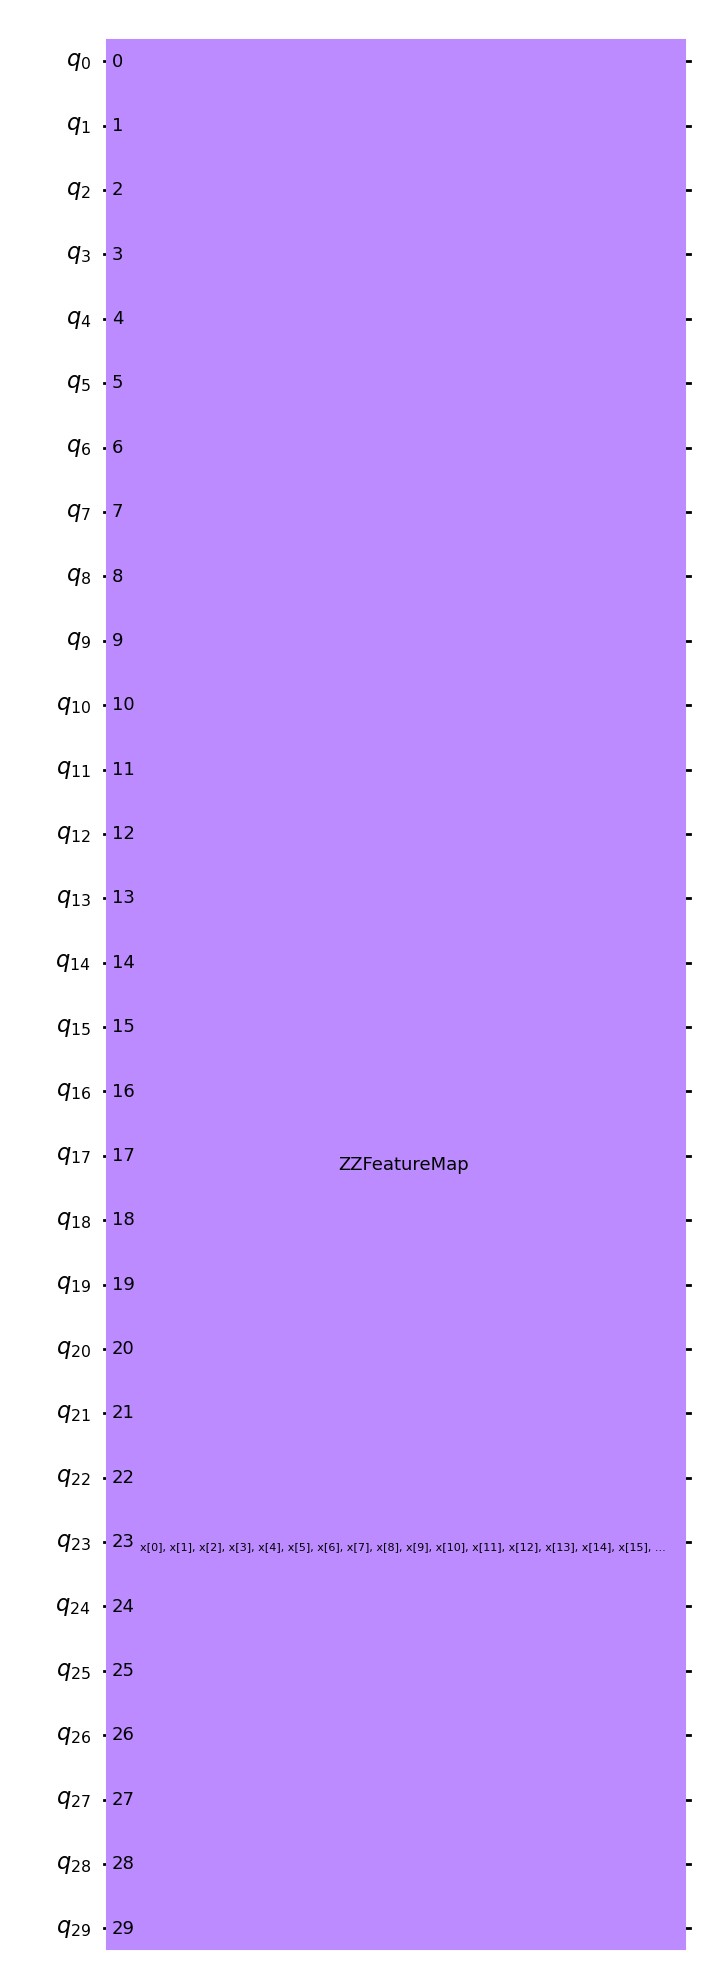

In [23]:
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap

MapChoice = ZZFeatureMap
feature_map = MapChoice(feature_dimension=X_train.shape[1], reps=2)

feature_map.draw("mpl")

Now it is the turn of the ansatz. We will select one of the following:

1. `TwoLocal`: Highly customizable, suitable for a wide range of variational quantum algorithms with adjustable single-qubit and entangling gates.
2. `PauliTwoDesign`: Focused on creating pseudo-random quantum states using Pauli gates, useful for simulations and benchmarking.
3. `RealAmplitudes`: Simpler and focused on real-number representations, suitable for problems solvable with real-valued amplitudes.

If the ansatz is too simple, it might not capture the complexity of the problem, leading to inadequate solutions. Conversely, an overly complex ansatz can lead to difficulties in optimization and increased computational resources. Therefore, balancing expressiveness (to represent the problem adequately) and manageability (to ensure computational efficiency) is key in selecting the appropriate ansatz for a given quantum computing task. And, similarly as happened with the feature map, there is no way of predicting which ansatz is more appropriate without knowing specific aspects of the data.

In our case, maybe the best ansatz is the `RealAmplitudes` because the dataset involves real-valued features, and the `RealAmplitudes` ansatz is designed to work with real numbers, potentially offering a more efficient and straightforward approach for this kind of data, but, on the other hand, an ansatz such as the `TwoLocal` may obtain some correlations that run across the `RealAmplitudes`. 

/home/jvazquez/miniconda3/envs/basic-quantum/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


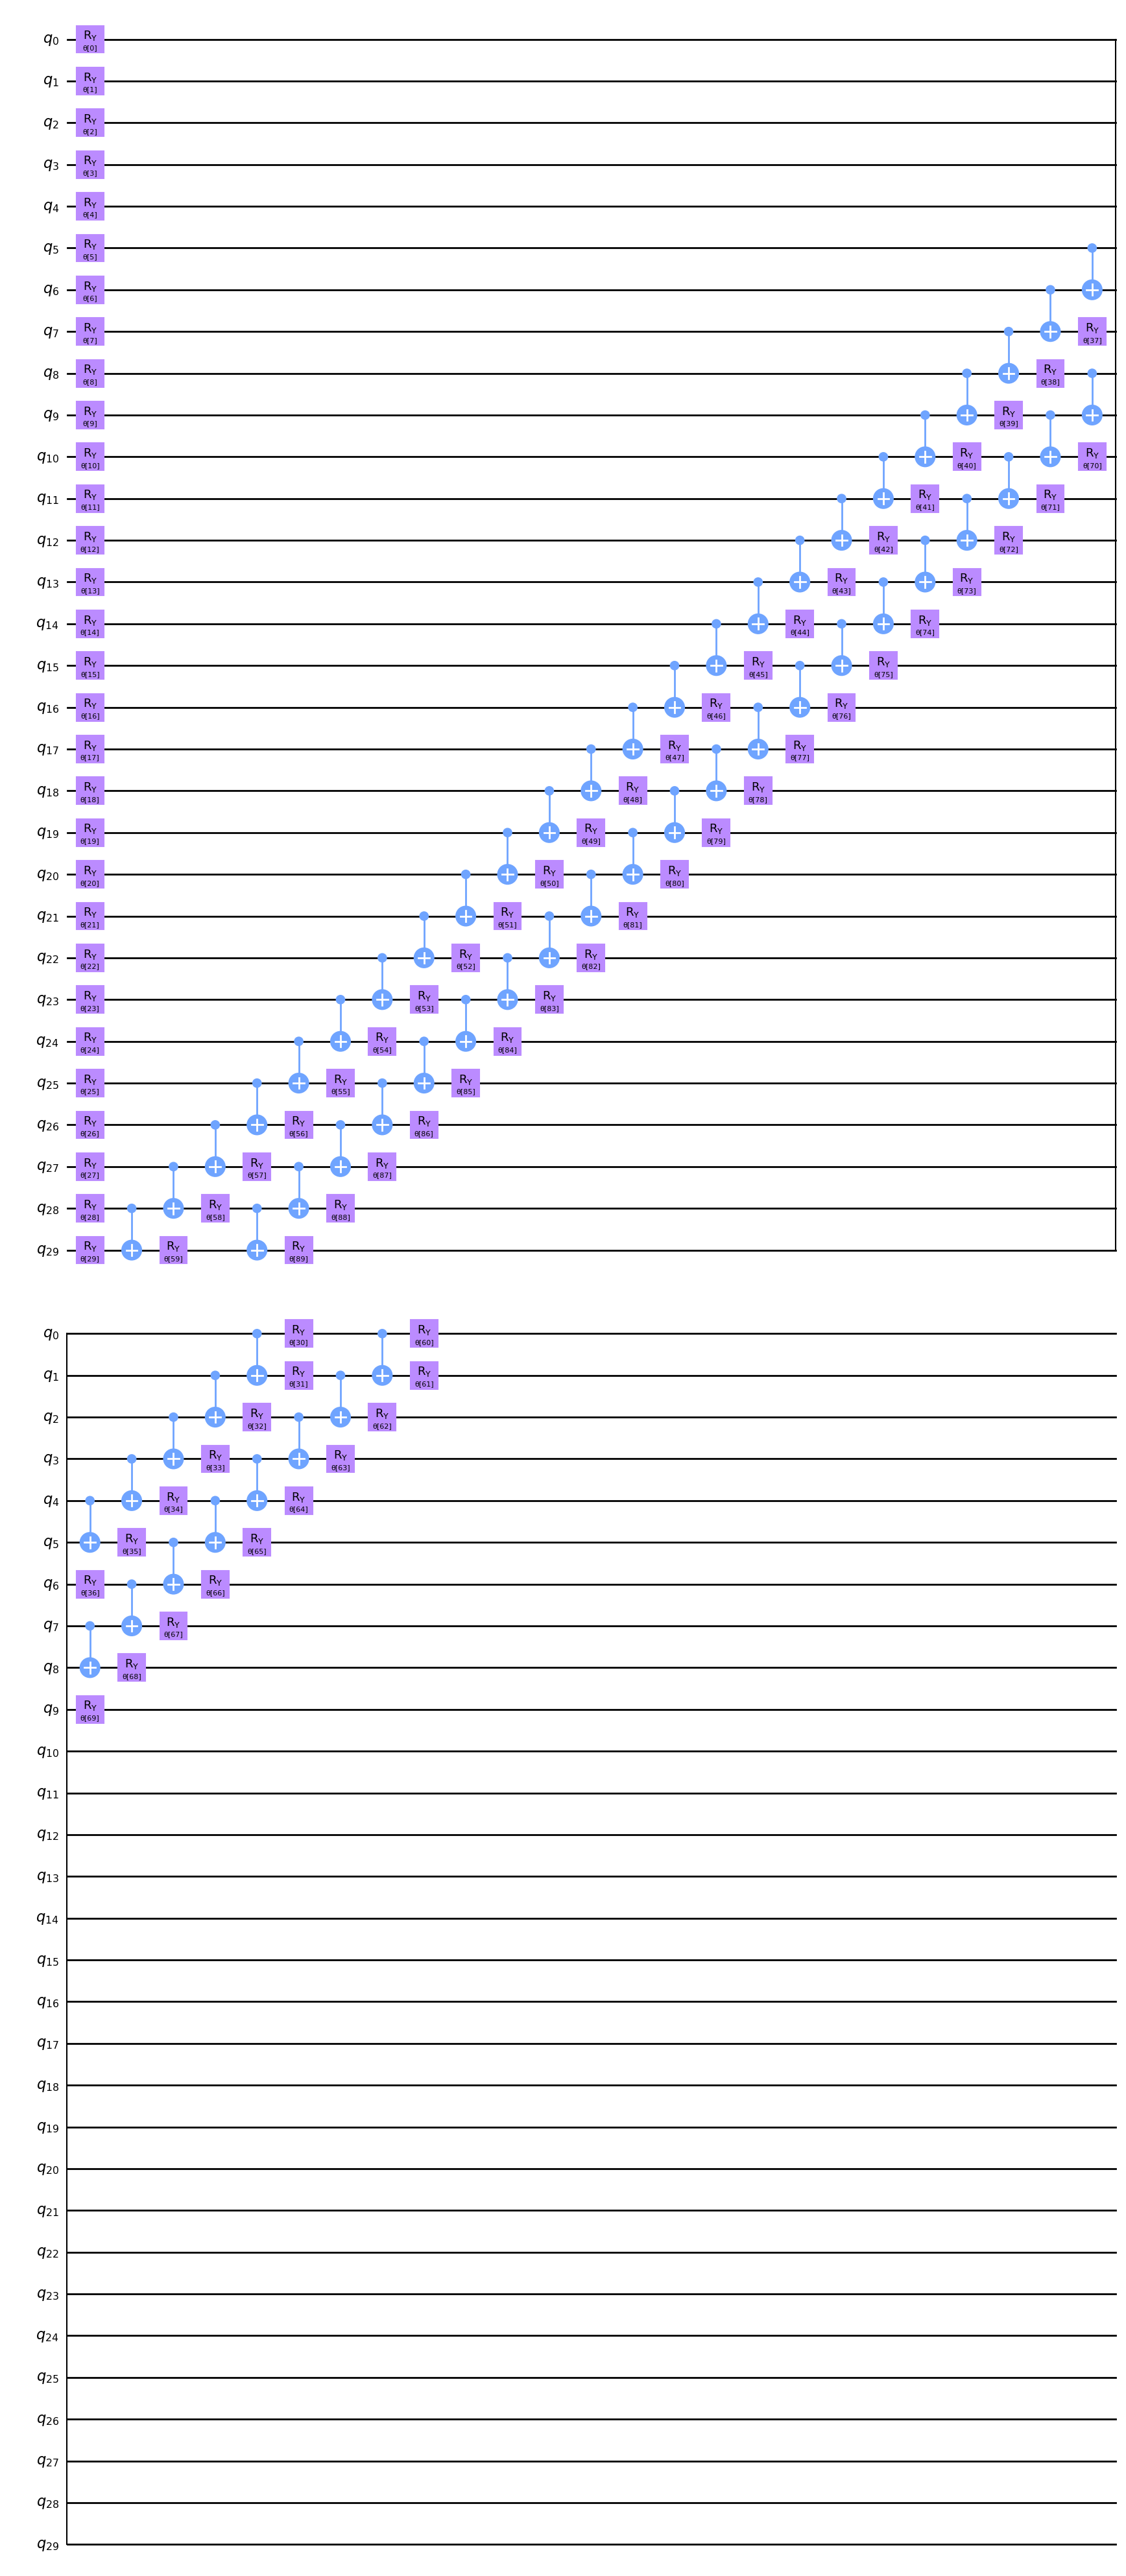

In [24]:
from qiskit.circuit.library import TwoLocal, PauliTwoDesign, RealAmplitudes

AnsatzChoice = RealAmplitudes
ansatz = AnsatzChoice(num_qubits=feature_map.num_qubits, reps=2)

ansatz.decompose().draw("mpl")

Finally, we have to define the optimizer to use and, a priori, we will choose between these three:

1. `COBYLA`: Best for small-scale, constraint-based problems where gradients are not available.
2. `ADAM`: Efficient for large-scale problems with its adaptive gradient mechanism, commonly used in deep learning.
3. `SPSA`: Suitable for high-dimensional problems, particularly in noisy environments, offering a gradient-free approach.

Unfortunately, the `ADAM` optimizer brings a lot of memory problems and, with the `TwoLocal` ansatz cannot directly execute. This is probably due to the specific implementation developed by Qiskit. It is a pity, because, in our case, `ADAM` could have been very effective, given its efficiency in handling gradient information and faster convergence. Alternatively, we will choose `COBYLA` due to its suitability for small-scale problems as this is. 

Ultimately, however, the effectiveness of these optimizers can also depend on the specific configuration of the quantum machine learning model and the quantum hardware being used, so empirical testing and adjustment might be necessary to determine the best optimizer for the dataset in a practical scenario, as it happened with the feature map and the ansatz. A problem that all the optimizers could face is Barren Plateaus, which refers to a problem where the landscape of the optimization function becomes flat, making it extremely difficult to train the model.

In [25]:
from qiskit.algorithms.optimizers import COBYLA, SPSA

OptimizerChoice = COBYLA
optimizer = OptimizerChoice(maxiter=100)

/tmp/ipykernel_5981/2555952395.py:1: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import COBYLA, SPSA


Now, we are in conditions to build the VQC using the preferred options to be able to train it and see if our guesses were correct.

In [ ]:
# 4. Build the variational quantum classifier using the feature map, ansatz, and optimizer

from qiskit_machine_learning.algorithms import VQC
from qiskit import Aer
from qiskit.primitives import Sampler
from IPython.display import clear_output
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler


# Array with the objective function values for each iteration
objective_func_vals = []

plt.rcParams["figure.figsize"] = (12, 6)
def callback_graph(weights, obj_func_eval):
    objective_func_vals.append(obj_func_eval)
    clear_output(wait=True)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

service = QiskitRuntimeService()
backend = service.backend("simulator_stabilizer")
sampler = Sampler(backend=backend)

vqc = VQC(feature_map=feature_map,
            sampler=sampler, 
            ansatz=ansatz,
            loss='cross_entropy',
            callback=callback_graph,
            optimizer=optimizer)

And now, once the VQC is built, we proceed to execute the VQC and check the results.

In [ ]:
import timeit
start = timeit.timeit()
vqc.fit(X_train, y_train)
end = timeit.timeit()
print(end - start)

The result are not displayed in the notebook due to its long compilation time. As we will see, almost every combination of elements (feature map, ansatz and optimizer) takes 3 hours to execute. Instead the code are snippets of the actual code executed on a HPC cluster. This is also a sign of the enourmous computational resources required nowadays to be able to perform even small trainings as we are doing with the breast cancer dataset.

Once this appreciation has being made, we proceed to say that the results were pretty poor, yielding a 60.00% rate of accuracy on the clasiffication. This is slightly better than an random guess (which corresponds with a 50% accuracy in this case, because there are 2 classes, benign and malign), but not near the 90% of accuracy that we usually get in this type of datasets in classical ML.

Due to the poor results yielded by our guess, we will test all the possible combinations to see which one performs best and to see how many time does each combination takes to execute.

In [ ]:
# Test the code with different map, ansatz, and optimizer
maps = [PauliFeatureMap, ZFeatureMap, ZZFeatureMap]
ansatzs = [TwoLocal, PauliTwoDesign, RealAmplitudes]
optimizers = [COBYLA, SPSA]

vqcs = {}


for map in maps:
    vqcs[map.__name__] = {}
    print(f"- Map: {map.__name__}")
    for ansatz in ansatzs:
        print(f"\t- Ansatz: {ansatz.__name__}")
        vqcs[map.__name__][ansatz.__name__] = {}
        for optimizer in optimizers:
            print(f"\t\t- Optimizer: {optimizer.__name__}")
            vqcs[map.__name__][ansatz.__name__][optimizer.__name__] = {}

            feature_map = map(feature_dimension=X_train.shape[1], reps=2)
            ansatz = ansatz(num_qubits=feature_map.num_qubits, reps=2)
            optimizer = optimizer(maxiter=100)

            objective_func_vals = []

            vqc = VQC(feature_map=feature_map,
                    sampler=Sampler(), 
                    ansatz=ansatz,
                    loss='cross_entropy',
                    callback=callback_graph,
                    optimizer=optimizer)
            vqc.fit(X_train, y_train)

            plt.savefig(f"map_{map.__name__}_ansatz_{ansatz.__name__}_optimizer_{optimizer.__name__}.png")

            vqcs[map.__name__][ansatz.__name__][optimizer.__name__]['vqc'] = vqc
            vqcs[map.__name__][ansatz.__name__][optimizer.__name__]['score'] = vqc.score(X_test, y_test)
            vqcs[map.__name__][ansatz.__name__][optimizer.__name__]['objective_func_vals'] = objective_func_vals
            print(f"\t\tMap: {map.__name__}, Ansatz: {ansatz.__name__}, Optimizer: {optimizer.__name__}")
            print(f"\t\tScore: {vqcs[map.__name__][ansatz.__name__][optimizer.__name__]['score']}")
            print("--------------------------------------------------------")

Just as before, due to long execution times, we will portrayed here the results obtained in the HPC cluster using the snippet showed above.

<center>

|   Feature map   |     Ansatz     | Optimizer | Accuracy | Time (s) |
|:---------------:|:--------------:|:---------:|:--------:|:--------:|
| PauliFeatureMap |    TwoLocal    |   COBYLA  |  50.78%  |  1,141.23 |
| PauliFeatureMap |    TwoLocal    |    SPSA   |  51.44%  |  1,141.56 |
| PauliFeatureMap | PauliTwoDesign |   COBYLA  |  58.89%  | 8,345.67 |
| PauliFeatureMap | PauliTwoDesign |    SPSA   |  52.22%  | 7,878.23 |
| PauliFeatureMap | RealAmplitudes |   COBYLA  |  58.89%  | 12,276.84 |
| PauliFeatureMap | RealAmplitudes |    SPSA   |  60.56%  | 10,344.45 |
|   ZFeatureMap   |    TwoLocal    |   COBYLA  |  53.33%  |  1,029.45 |
|   ZFeatureMap   |    TwoLocal    |    SPSA   |  58.89%  |  1,444.11 |
|   ZFeatureMap   | PauliTwoDesign |   COBYLA  |  71.11%  | 13,213.23 |
|   ZFeatureMap   | PauliTwoDesign |    SPSA   |  61.67%  | 7,463.43 |
|   ZFeatureMap   | RealAmplitudes |   COBYLA  |  90.14%  | 13,789.65 |
|   ZFeatureMap   | RealAmplitudes |    SPSA   |  79.44%  | 15,611.54 |
|   ZZFeatureMap  |    TwoLocal    |   COBYLA  |  55.00%  |  1,030.78 |
|   ZZFeatureMap  |    TwoLocal    |    SPSA   |  53.33%  |  1,546.77 |
|   ZZFeatureMap  | PauliTwoDesign |    SPSA   |  60.82%  | 10,334.46 |
|   ZZFeatureMap  | PauliTwoDesign |    SPSA   |  57.78%  | 11,123.56 |
|   ZZFeatureMap  | RealAmplitudes |   COBYLA  |  70.00%  | 13,324.23 |
|   ZZFeatureMap  | RealAmplitudes |    SPSA   |  52.22%  | 15,234.43 |
</center>

And we see that the best accuracy, by far, is yielded by the `ZFeatureMap` map with the `RealAmplitudes` ansatz using `COBYLA` resulting in a 90,14% of accuracy. We were wrong guessing that the feature-feature interactions were important for the classifying the cancer types, but, instead, the simplicity of the `ZFeatureMap` map resulted in a much better classification.

If we focus on the general results, we can extract some conclusions from each part of the QNN. Below, we can see the accuracy of each type of each part in the charts. Let's analyze them.

- **Feature map.** First of all, it shows that the `ZFeatureMap` is consistenly better that the other two feature maps considered as we have seen in the best accuracy displayed in the table. Moreover, we can see that, in average, the `PauliFeatureMap` and the `ZZFeatureMap` result in similar accuracies. This could be explained by the complexity of those two maps in comparison with the `ZFeatureMap`.
- **Ansatz**. The most outstanding result is that the `TwoLocal` is the the worst ansatz possible from the three available, but, if look at the table, the surprise is even bigger due to the short time taken to execute. This is extremely rare and is almost like Qiskit rejects the training of this type of ansatz for unknown reasons. On the other hand, the `RealAmplitudes` ansatz responds notably better that the other two, but not excellent, reaching below 50% on average.
- **Optimizer**. Last but no least, we see that the `COBYLA` optimizer outperforms the SPSA optimizer.
  

## 4. Develop a classical SVM <a class="anchor" id="apartado4"></a>

Taking the whole dataset and trying the logistic regression and the different models for SVM, we get the following results.

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Train logistic regression model
lr_model = LogisticRegression(max_iter=120)
lr_model.fit(X_train, y_orig_train)

# Train linear SVM model
linear_svm_model = SVC(kernel='linear')
linear_svm_model.fit(X_train, y_orig_train)

# Train kernelized SVM model
kernel_svm_model = SVC(kernel='rbf')
kernel_svm_model.fit(X_train, y_orig_train)

lr_accuracy = lr_model.score(X_test, y_orig_test)
print(f"LR \t\t- Classification Accuracy: {lr_accuracy}")

linear_svm_accuracy = linear_svm_model.score(X_test, y_orig_test)
print(f"Linear SVM \t- Classification Accuracy: {linear_svm_accuracy}")

kernel_svm_accuracy = kernel_svm_model.score(X_test, y_orig_test)
print(f"Kernel SVM \t- Classification Accuracy: {kernel_svm_accuracy}")

LR 		- Classification Accuracy: 0.9473684210526315
Linear SVM 	- Classification Accuracy: 0.956140350877193
Kernel SVM 	- Classification Accuracy: 0.9210526315789473


This shows that the lineal models do not have anything to envy, in this case, of the NN. Nor the classical NN neither the QNN. The accuracies are really similar, hinting a separable nature of the benign and malign cancers with regards of the kind of features stored in the dataset.

## 5. Develop a quantum SVM <a class="anchor" id="apartado5"></a>

For the classification we use the SVM model of `sklearn` with the `rbf` kernel in the classical case and with the custom quantum kernel in this case.

In [ ]:
from sklearn.svm import SVC
from qiskit_machine_learning.kernels import FidelityQuantumKernel

feature_map = ZZFeatureMap(feature_dimension=30, reps=2, entanglement="linear")
quantum_kernel = FidelityQuantumKernel(feature_map=feature_map)

quantum_svc = SVC(kernel=quantum_kernel.evaluate).fit(X_train, y_orig_train)
quantum_train_score = quantum_svc.score(X_train, y_orig_train)
quantum_test_score = quantum_svc.score(X_test, y_orig_test)

In this case, similar to the QNN is really heavy for computing in a notebook so, again, we will execute this code in a script on a HPC cluster. The score obtained was 80.1% for the training set and 74.2% for the test. This are poor results in comparison with the 95% accuracy that the classical models yielded.

This could be due to the fact that the dimension in which the data is already satisfies the linear separabilty that we are looking for and, on the contrary, when going to a higher dimension with the quantum feature map, some "noise" is introduce, making the final classification worse.

To try and solve this we will apply a preprocessing of the data using kPCA and, as we have seen in QNN, we are going to get rid of the `ZZFeatureMap` and use the `ZFeatureMap` instead.

In [ ]:
from qiskit.circuit.library import ZFeatureMap
from sklearn.decomposition import KernelPCA

feature_map = ZFeatureMap(feature_dimension=4, reps=2)
quantum_kernel = FidelityQuantumKernel(feature_map=feature_map)

orig_matrix_train = quantum_kernel.evaluate(x_vec=X_train)
orig_matrix_test = quantum_kernel.evaluate(x_vec=X_test, y_vec=X_train)
quantum_kernel_pca = KernelPCA(n_components=4, kernel="precomputed").fit(orig_matrix_train)
quantum_X2_train = quantum_kernel_pca.transform(orig_matrix_train)
quantum_X2_test = quantum_kernel_pca.transform(orig_matrix_test)

# Using Quantum kPCA preprocessing
logistic_regression = LogisticRegression(C=10).fit(quantum_X2_train, y_train)

logistic_score = logistic_regression.score(quantum_X2_train, y_train)
print(f"Logistic regression (Quantum kPCA preprocessed) train score: {logistic_score}")
logistic_score = logistic_regression.score(quantum_X2_test, y_test)
print(f"Logistic regression (Quantum kPCA preprocessed) test score: {logistic_score}")

Now, the results are much better, achieving a 87.45% of accuracy on the training set and 87.01% on the test set.

## 6. Conclusions <a class="anchor" id="apartado6"></a>

Reflecting on the practice we have undertaken with the breast cancer dataset, it's evident that we have covered several crucial steps in the deep learning workflow. Let's discuss insights gained from each of these stages:

1. **Preprocessing**: In this stage, we applied various essential steps, including `MinMaxScaler()` of the data and one-hot encoding of labels. These actions ensure that the neural network and the rest of the models receive data in a format it can readily process, enhancing efficiency and effectiveness in learning. Additionally, the dataset was divided into training and validation sets, enabling the monitoring of the model's performance on unseen data. This practice facilitates generalization while guarding against overfitting.

2. **Developing a Neural Network**: In this phase, decisions regarding structural hyperparameters such as the number of layers, neurons, and activation functions were pivotal. Striking the right balance between too many and too few layers or neurons is critical to prevent overfitting or underfitting. We arrived at an optimal compromise for performance, as measured by validation accuracy, and computational resources. This resulted in a model with two hidden layers comprising 32 neurons and the commonly used ReLU activation function. For learning hyperparameters (optimizer, learning rate, epochs, metrics and batch size), we adopted a grid search approach (excepting batch size, which value was argued in the text). Finally, we explored various regularization techniques, including dropout, batch normalization, weight regularization, and weight initialization, to mitigate overfitting. Among these methods, only dropout and weight initialization did not lead to a reduction in accuracy, and therefore, they was selected to be incorporated into the model.

3. **Developing a Quantum Neural Network**: In our study, we applied quantum machine learning (QML) techniques to the breast cancer dataset from sklearn, exploring the integration of quantum computing concepts such as feature maps, ansatzes, and optimizers into classical machine learning classification tasks. We focused on differentiating between the quantum circuit's feature map and ansatz, finding that the `ZFeatureMap` and `RealAmplitudes` ansatz were particularly effective for this dataset. For optimization, `COBYLA` proved to be the most efficient due to its suitability for small-scale problems. We encountered typical QML challenges like the complexity of quantum state manipulation and the occurrence of barren plateaus in optimization landscapes. This research underscores the potential and complexities of QML, highlighting the importance of careful component selection and a deep understanding of quantum mechanics and machine learning to effectively implement QML in practical scenarios.

4. **Developing a Classic SVM**: In this phase, our approach involved constructing a logistic regression model alongside two distinct SVM models, each employing a different kernel. This diversification in modeling techniques was strategic, allowing us to explore various facets of the dataset's structure. Remarkably, each of these models – logistic regression and both SVMs – mirrored the performance metrics achieved earlier with the neural network. This consistency across different methodologies strongly suggested that the dataset possesses a linearly separable nature. The logistic regression model offered insight into the basic linear relationships within the data, while the SVMs, with their unique kernels, provided a more nuanced understanding, adapting to potential non-linearities. The close alignment of results across all models underscored a fundamental characteristic of the dataset, paving the way for more targeted and refined analytical strategies.

5. **Developing a Quantum SVM**: Extending our exploration into the quantum realm, we developed a quantum SVM model, analogous in purpose to its neural network counterpart. However, the results from this quantum SVM were notably less impressive than those achieved with the classical models. This outcome sheds light on the current limitations and challenges inherent in quantum computing applications in machine learning. Despite the theoretical advantages that quantum algorithms are purported to hold, such as processing speed and handling of complex data patterns, our practical experience pointed to a significant performance gap. This quantum SVM, while an innovative venture into leveraging quantum mechanics for data analysis, struggled with issues like error rates, qubit coherence, and the intricacies of quantum state manipulation. These challenges, emblematic of the nascent stage of quantum computing technology, underscored the gap between theoretical potential and current practical execution, particularly in comparison with the more mature and optimized classical machine learning methods.

These insights and the practices we followed have collectively contributed to the development of an effective deep learning and linear models for the breast cancer dataset. In the realm of machine learning, this evidence suggests that quantum methods, on the whole, tend to underperform compared to their classical counterparts. Despite the theoretical promise and potential quantum computing holds, practical applications in machine learning often reveal that quantum algorithms struggle to match the efficiency, accuracy, and scalability achieved by established classical methods. This discrepancy is primarily due to the nascent stage of quantum computing technology, which faces significant challenges. Additionally, many machine learning tasks, particularly those involving large datasets or requiring robust error tolerance, are currently better handled by classical algorithms, which have been extensively optimized over years of research and application. As quantum technology continues to develop, it may eventually bridge or even surpass this performance gap, but as of now, classical machine learning methods remain more effective for most practical applications.